## Semantic Search with Dense Vector Embeddings

In [1]:
import sys
sys.path.append("..")
from aips import *
import pandas
import pickle
import json
import tqdm
pandas.set_option('display.max_rows', 1000)

## Load and clean the Outdoors dataset

## Transformer time!

In [2]:
from sentence_transformers import SentenceTransformer, util as STutil
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

## Listing 13.16

In [4]:
from densevectors.outdoors import *
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
outdoors_dataframe = clean_dataset("../data/outdoors/posts.csv")
def get_embeddings(sentences,load_from_cache=True):
    if not load_from_cache:
        embeddings = stsb.encode(sentences, convert_to_tensor=True)
        with open("../data/outdoors/outdoors_semantic_search_embeddings.pickle","wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open("../data/outdoors/outdoors_semantic_search_embeddings.pickle","rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

titles = list(filter(None, list(outdoors_dataframe["title"]))) 
#set load_from_cache=False to regenerate the embeddings rather than loading from pickle
embeddings = get_embeddings(titles, load_from_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

/home/jovyan/notebooks/densevectors/outdoors.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(h, 'lxml')


Number of embeddings: 5331
Dimensions per embedding: 768


### Explore the top similarities for the titles

In [ ]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities) - 1):
    for b in range(a + 1, len(similarities)):
        a_phrases.append(titles[a])
        b_phrases.append(titles[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                "score": scores, "name": "similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"] > 0.5]

,phrase a,phrase b,score,name,idx
0,How do I recognize if someone is suffering fro...,How should I treat hypothermia?,0.846395,similarity,0
1,How should I treat poison ivy?,What can I do to prevent getting poison ivy?,0.811995,similarity,1
2,What is the difference between the different t...,What is the difference between camber and rock...,0.800817,similarity,2
3,How do I tie a sleeping bag to my backpack?,What is the best way to store my sleeping bag ...,0.794242,similarity,3
4,What should I look for if I want to buy a wint...,What is the best way to store my tent?,0.790016,similarity,4
5,How do I set a top rope anchor?,How do I inspect a climbing rope?,0.753913,similarity,5
6,What is the safest way to purify water?,What are the different methods to purify water?,0.745218,similarity,6
7,"What do I need to look for in good, quality hi...",What is the difference between men's and women...,0.710361,similarity,7
8,"What to look for in a durable, 3-season sleepi...",What is the best way to store my sleeping bag ...,0.704152,similarity,8
9,How should I check that the anchor is secure w...,How do I set a top rope anchor?,0.698881,similarity,9


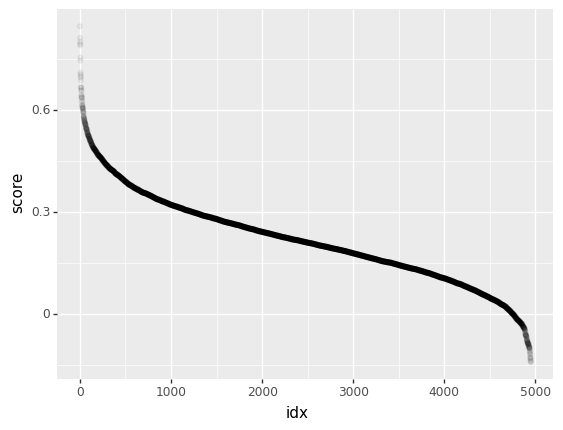

{<ggplot: (8794541302370)>}

In [ ]:
from plotnine import *
{
    ggplot(comparisons, aes("idx", "score"))+ geom_point(alpha=.05)
}

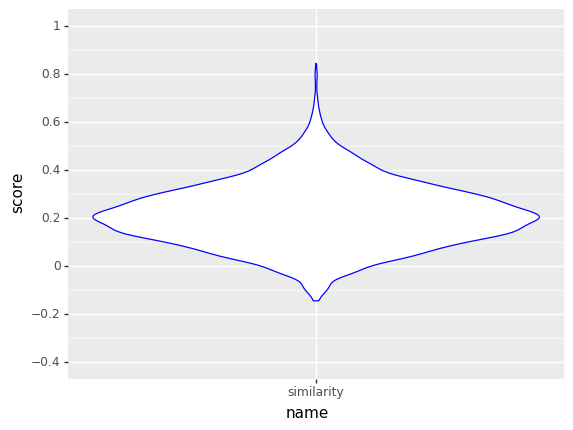

{<ggplot: (8794541563745)>}

In [ ]:
from plotnine import *
{
    ggplot(comparisons, aes("name", "score")) +
    geom_violin(color="blue") + 
    scale_y_continuous(limits=[-0.4, 1.0], breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.17


### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [16]:
import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
titles_index = nmslib.init(method="hnsw", space="cosinesimil")
titles_index.addDataPointBatch(embeddings)
titles_index.createIndex(print_progress=True)

['Are there any cheap 1:25K electronic maps for the UK or Europe?', 'What attributes should I look for in an inexpensive multi-purpose folding bike?', 'Where can I find good topographical maps of Peru?', 'How to cross a 25 feet wide Crevasse?', 'Do folding cross country skis exist?', 'Free online UK maps', 'Are there any affordable night vision goggles that are good and available to civilians?', 'How safe is it to travel from Kathmandu to Lukla without Flying the distance?', 'What are the differences between expensive, mid-priced and cheap skis?', 'What exactly do the 2 knobs on my Zeiss 10 × 25B binoculars do?']


## Listing 13.18

In [ ]:
#dedup these two functions from 13.3
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for l, d in matches:
        print(str(int(d*1000)/1000), "|", l)
        
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    embeddings = stsb.encode([query], convert_to_tensor=True)
    ids, distances = index.knnQuery(embeddings[0], k=k)
    for i in range(len(ids)):
        distance = 1.0 - distances[i]
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], 1.0 - distances[1]))
    return matches

def semantic_search(query, phrases):
    return embedding_search(titles_index, query, phrases, 10, 0.6)

In [18]:
results = semantic_search("mountain hike", titles)
print_labels("mountain hike", results)

0.723 | How is elevation gain and change measured for hiking trails?
0.715 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.698 | Hints for hiking the west highland way
0.694 | New Hampshire A.T. Section Hike in May? Logistics and Trail Conditions
0.678 | Long distance hiking trail markings in North America or parts thereof
0.671 | How far is a reasonable distance for someone to hike on their first trip?
0.67 | Vancouver Sunrise Hike Advice?
0.668 | How to prepare on hiking routes?
0.667 | Camping on top of a mountain
0.662 | Advice for first Grand Canyon Hike for Eastern Hikers


In [ ]:
embeddings.shape

torch.Size([5331, 768])

## Visualize the titles in 3d vector space

/tmp/ipykernel_3636/2932374821.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


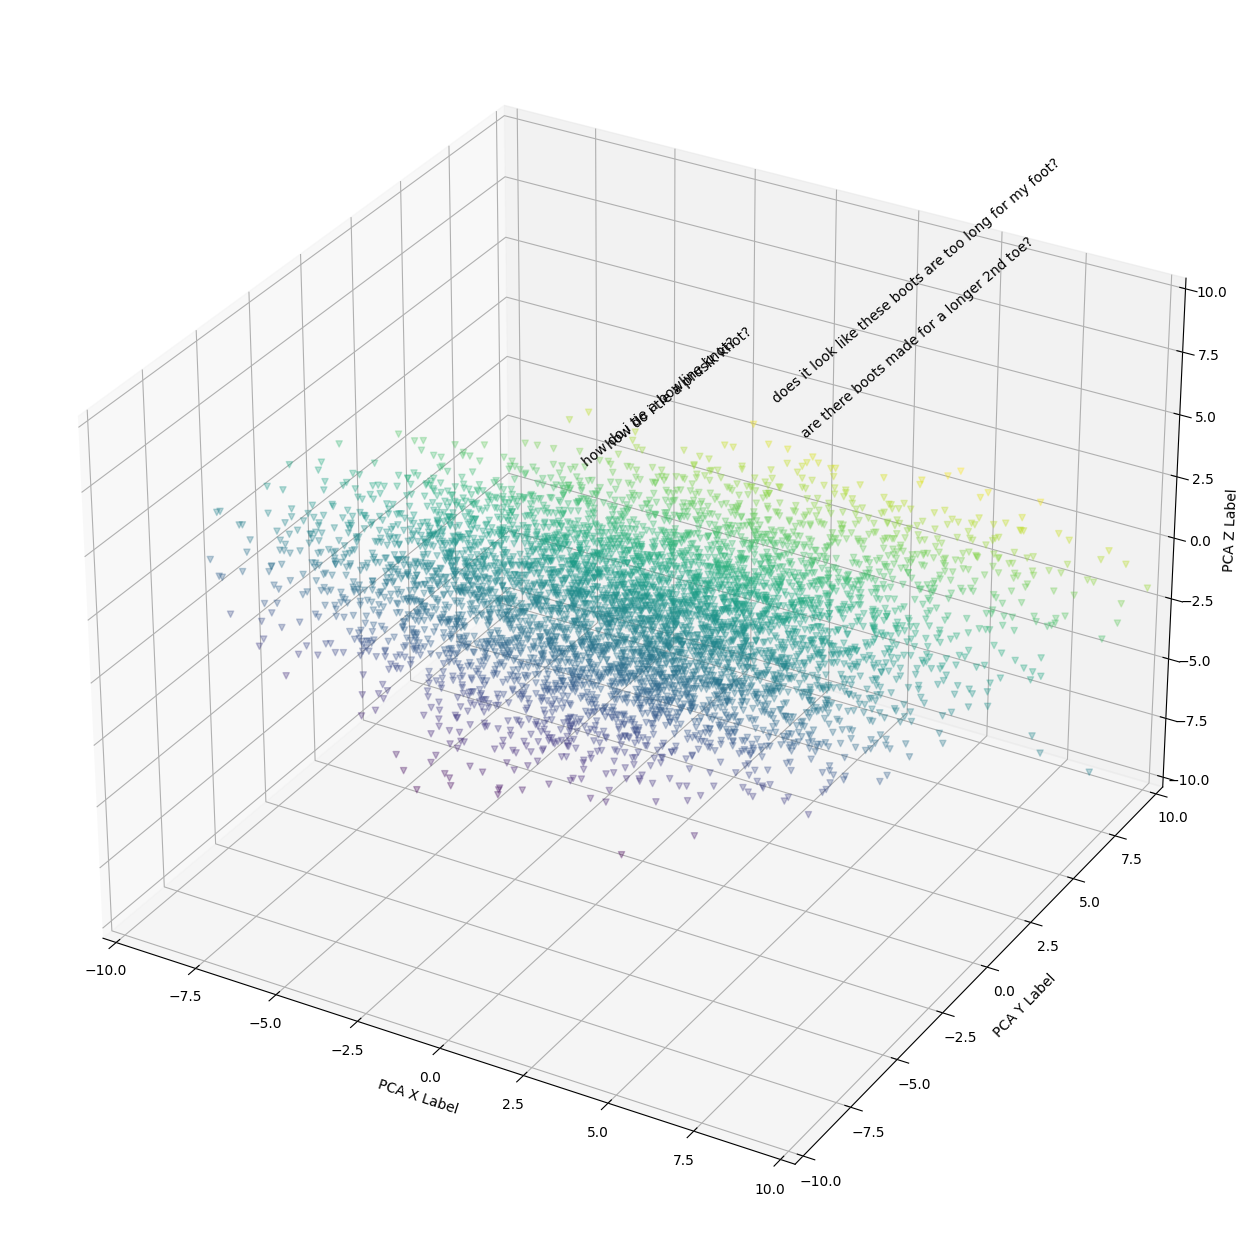

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = titles_index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = titles_index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [titles[idx].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel("PCA X Label")
ax.set_ylabel("PCA Y Label")
ax.set_zlabel("PCA Z Label")
plt.show()

Up next: [Chapter 14: Question Answering with a Fine-tuned Large Language Model](../ch14/1.question-answering-visualizer.ipynb)